# Transpiling ControlNet

Transpiling `ControlNet` using `ivy` to show Latency Speedup

If you already have `Ivy` installed you can skip this cell, but if you are using Colab, you will have to install `Ivy` manually. You can do so by running the cell below ⬇️

Keep in mind that for the package to be available, you will have to click on **"Runtime > Restart Runtime"** 😄

In [1]:
API_KEY = "API_KEY"
!mkdir -p .ivy
!echo -n $API_KEY > .ivy/key.pem

In [2]:
!pip install -q ivy

!pip install -q diffusers torch numpy transformers jax jaxlib dm-haiku accelerate

Let's now import `ivy` and other `libraries` and `modules` we will be using in this example

In [3]:
from diffusers import StableDiffusionControlNetInpaintPipeline, ControlNetModel, DPMSolverMultistepScheduler
from diffusers.utils import load_image
from PIL import Image
import transformers
import numpy as np
import torch
import jax
import ivy
import PIL

/workspaces/demos/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Set the path to store the `cache` of the model

In [4]:
cache_path = "cache/"

Now we can load `ControlNet` from HuggingFace Models repository!

In [5]:
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_inpaint",
    torch_dtype=torch.float32,
    cache_dir=cache_path,
    # local_files_only=True
)

We will use `StableDiffusionControlNetInpaintPipeline` from `diffusers` library for this example

In [6]:
pipe = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    controlnet=controlnet,
    torch_dtype=torch.float32,
    # local_files_only=True,
    cache_dir=cache_path,
)

safety_checker/model.safetensors not found
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


Initializing a scheduler for a `Distributed Proximal Methods (DPM)` solver using a multistep scheduling strategy.

In [7]:
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Let's now load the **image** and the **image mask** we would need for this example!
We can use one of the images provided in the datasets of `diffusers` on HuggingFace Datasets repository.

*Note: You can also use your own image and mask for this!*

In [8]:
init_image = load_image(
    "https://huggingface.co/datasets/diffusers/test-arrays/resolve/main/stable_diffusion_inpaint/boy.png"
)
init_image = init_image.resize((512, 512))

torch_generator = torch.Generator(device="cpu").manual_seed(1)

mask_image = load_image(
    "https://huggingface.co/datasets/diffusers/test-arrays/resolve/main/stable_diffusion_inpaint/boy_mask.png"
)
mask_image = mask_image.resize((512, 512))

Create a *condition* function for *inpainting* the image to create a control image!
This condition is based on the mask pixel values, wherever the mask pixel value is greator then 0.5, we will inpaint that pixel to a value of -1.0

In [9]:
def make_inpaint_condition(image, image_mask):
    image = np.array(image.convert("RGB")).astype(np.float32) / 255.0
    image_mask = np.array(image_mask.convert("L")).astype(np.float32) / 255.0

    assert image.shape[0:1] == image_mask.shape[0:1], "image and image_mask must have the same image size"
    image[image_mask > 0.5] = -1.0  # set as masked pixel
    image = np.expand_dims(image, 0).transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return image

Create a control image using the condition function we created!

In [10]:
control_image = make_inpaint_condition(init_image, mask_image)

In [11]:
inputs = {
    "prompt":"a handsome man with ray-ban sunglasses",
    "num_inference_steps":20,
    "eta":1.0,
    "image":init_image,
    "mask_image":mask_image,
    "control_image":control_image,
}

Now we can use the Pipeline for our diffusion task. We need to provide `a prompt`, `image to diffuse`, `mask image` and `control image`

In [12]:
image = pipe(
    **inputs,
).images[0]

100%|██████████| 20/20 [03:18<00:00,  9.92s/it]


In [13]:
jax_pipeline = ivy.transpile(pipe, source="torch", to="jax")

In [14]:
type(jax_pipeline)

IIV.LazyGraph

In [ ]:
output = jax_pipeline(**inputs).images[0]

Lets visualize our results!

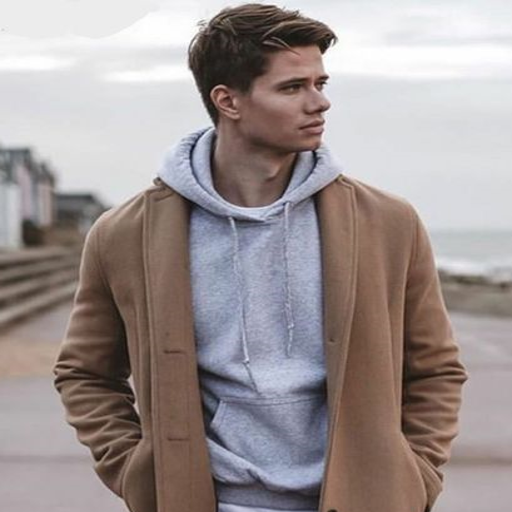

In [15]:
init_image

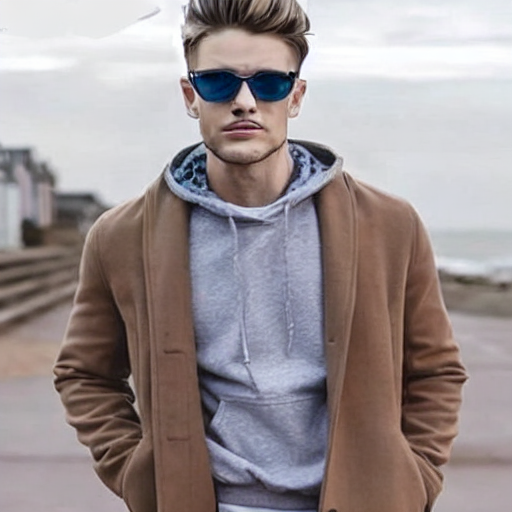

In [16]:
image

In [ ]:
output